In [ ]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm # Colormaps
from matplotlib.colors import colorConverter, ListedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=4)
#

In [ ]:
# Define and generate the samples
nb_of_samples_per_class = 20  # The number of sample in each class
blue_mean = 0  # The mean of the blue class
red_left_mean = -2  # The mean of the red class
red_right_mean = 2  # The mean of the red class

std_dev = 0.5  # standard deviation of both classes
# Generate samples from both classes
xs_blue = np.random.randn(
    nb_of_samples_per_class, 1) * std_dev + blue_mean
xs_red = np.vstack((
    np.random.randn(  # Red star left samples
        nb_of_samples_per_class//2, 1) * std_dev + red_left_mean,
    np.random.randn(  # Red star right samples
        nb_of_samples_per_class//2, 1) * std_dev + red_right_mean
))

# Merge samples in set of input variables x, and corresponding set of
# output variables t
x = np.vstack((xs_blue, xs_red))
t = np.vstack((np.ones((xs_blue.shape[0], 1)), 
               np.zeros((xs_red.shape[0], 1))))
#

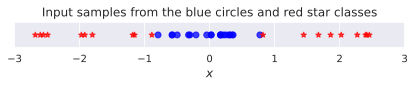

In [ ]:
# Plot samples from both classes
fig = plt.figure(figsize=(7, 1))
plt.xlim(-3,3)
plt.ylim(-1,1)
# Plot samples
plt.plot(xs_blue, np.zeros_like(xs_blue), 'bo', alpha=0.75)
plt.plot(xs_red, np.zeros_like(xs_red), 'r*', alpha=0.75)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Input samples from the blue circles and red star classes')
plt.xlabel('$x$', fontsize=12)
fig.subplots_adjust(bottom=0.4, top=0.75)
plt.show()
#

In [ ]:
def rbf(zh):
    """RBF activation function"""
    return np.exp(-zh**2)

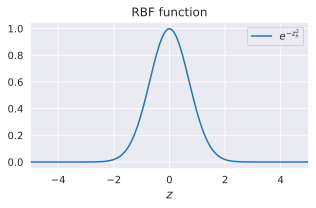

In [ ]:
# Plot the rbf function
zhs = np.linspace(-5, 5, 100)
fig = plt.figure(figsize=(5, 3))
plt.plot(zhs, rbf(zhs), label='$e^{-z_h^2}$')
plt.xlabel('$z$', fontsize=12)
plt.title('RBF function')
plt.legend()
plt.xlim(-5, 5)
fig.subplots_adjust(bottom=0.2)
plt.show()
#

In [ ]:
def logistic(zo):
    """Logistic classifiction function"""
    return 1. / (1. + np.exp(-zo))


def hidden_activations(x, wh):
    """Hidden layer activations from RBF."""
    return rbf(x * wh)


def output_activations(h , bo):
    """Logistic classification output."""
    return logistic(h + bo)


def nn(x, wh, bo):
    """Full neural network function."""
    return output_activations(hidden_activations(x, wh), bo)


def nn_predict(x, wh, bo):
    """Neural network prediction function that only returns
    1 or 0 depending on the predicted class."""
    return np.around(nn(x, wh, bo))

In [ ]:
def loss(y, t):
    """Cross entropy loss function."""
    return -np.mean(
        (t * np.log(y)) + ((1-t) * np.log(1-y)))

 
def loss_for_param(x, wh, bo, t):
    """Calculate the loss for a given set of parameters."""
    return loss(nn(x, wh, bo) , t)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


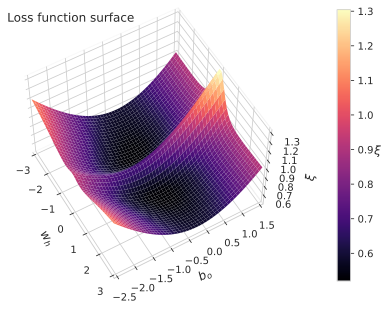

In [ ]:
# Plot the loss in function of the weights
# Define a vector of weights for which we want to plot the loss
grid_size = 50 # Grid used to plot loss surface
wsh = np.linspace(-3, 3, num=grid_size) # hidden weights
bso = np.linspace(-2.5, 1.5, num=grid_size) # output weights
params_x, params_y = np.meshgrid(wsh, bso) # generate grid
# Initialise loss surface grid
loss_grid = np.zeros((grid_size, grid_size))
# Fill the loss matrix for each combination of weights
for i in range(grid_size):
    for j in range(grid_size):
        loss_grid[i,j] = loss(
            nn(x, params_x[i,j], params_y[i,j]) , t)
# Plot the loss function surface
fig = plt.figure(figsize=(7, 5))
with sns.axes_style("whitegrid"):
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    # plot the surface
    surf = ax.plot_surface(
        params_x, params_y, loss_grid, linewidth=0, cmap=cm.magma)
    ax.view_init(elev=55, azim=-30)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    cbar = fig.colorbar(surf, pad=0.15)
    ax.set_xlabel('$w_h$', fontsize=12)
    ax.set_ylabel('$b_o$', fontsize=12)
    ax.set_zlabel('$\\xi$', fontsize=12)
    ax.set_ylim(-2.5, 1.5)
    ax.set_xlim(-3, 3)
    cbar.ax.set_ylabel('$\\xi$', fontsize=12, rotation=0)
    ax.set_title('Loss function surface', loc='left', y=1.0, pad=-12)
plt.show()
#

In [ ]:
def gradient_output(y, t):
    """Gradient of loss output."""
    return y - t


def gradient_bias_out(grad_output): 
    """Gradient off the bias parameter at the output layer."""
    return grad_output


def gradient_hidden(grad_output):
    """Gradient of hidden layer output."""
    return grad_output


def gradient_weight_hidden(x, zh, h, grad_hidden):
    """Gradient of hidden layer weight parameter wh."""
    return x * -2 * zh * h * grad_hidden

In [ ]:
def backprop_update(x, t, wh, bo, learning_rate):
    """Full backpropagation update function.
    Updates the parameters bo and wh in 1 iteration."""
    # Compute the output of the network
    # This can be done with y = nn(x, wh, bo), but we need
    #  the intermediate h and zh for the weight updates.
    zh = x * wh
    h = rbf(zh)  # h = hidden_activations(x, wh)
    y = output_activations(h, bo)
    # Compute the gradient at the output
    grad_output = gradient_output(y, t)
    # Get the delta for bo
    d_bo = learning_rate * gradient_bias_out(grad_output)
    # Compute the gradient at the hidden layer
    grad_hidden = gradient_hidden(grad_output)
    # Get the delta for wh
    d_wh = learning_rate * gradient_weight_hidden(
        x, zh, h, grad_hidden)
    # return the update parameters
    return float(np.mean(wh-d_wh)), float(np.mean(bo-d_bo))

In [ ]:
# Run backpropagation
# Set the initial weight parameter
wh = 2.3  # Randomly decided
bo = 1.4  # Randomly decided
# Set the learning rate
learning_rate = 2.0

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 20  # number of gradient descent updates
# List to store the weight values for later vizualization
params_loss = [(wh, bo, loss_for_param(x, wh, bo, t))]
for i in range(nb_of_iterations):
    # Update the weights via backpropagation
    wh, bo = backprop_update(x, t, wh, bo, learning_rate)
    # Store the values for plotting
    params_loss.append((wh, bo, loss_for_param(x, wh, bo, t)))

# Print the final loss
final_loss = loss_for_param(x, wh, bo, t)
print(f'final loss is {final_loss:.2f} for weights',
      f'wh={wh:.2f} and bo={bo:.2f}')

final loss is 0.52 for weights wh=1.12 and bo=-0.44


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  if sys.path[0] == '':


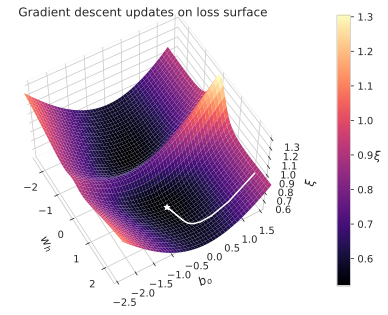

In [ ]:
# Plot the weight updates on the error surface
# Plot the error surface
fig = plt.figure(figsize=(7, 5))
with sns.axes_style("whitegrid"):
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    surf = ax.plot_surface(
        params_x, params_y, loss_grid, linewidth=0, cmap=cm.magma)
    ax.view_init(elev=55, azim=-30)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    cbar = fig.colorbar(surf, pad=0.15)
    cbar.ax.set_ylabel('$\\xi$', fontsize=12, rotation=0)

    # Plot the updates
    for i in range(1, len(params_loss)):
        wh1, bo1, l1 = params_loss[i-1]
        wh2, bo2, l2 = params_loss[i]
        # Plot the update 
        ax.plot([wh1, wh2], [bo1, bo2], [l1, l2], 'w-')
    ax.plot(*params_loss[-1], color='w', marker='*')
    # Show figure
    ax.set_xlabel('$w_h$', fontsize=12)
    ax.set_ylabel('$b_o$', fontsize=12)
    ax.set_zlabel('$\\xi$', fontsize=12)
    ax.set_ylim(-2.5, 1.5)
    ax.set_xlim(-2.5, 2.5)
    ax.set_title('Gradient descent updates on loss surface', pad=-1)
plt.show()
#

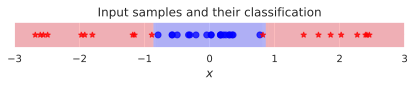

In [ ]:
# Plot the resulting decision boundary
# Generate a grid over the input space to plot the color of the
#  classification at that grid point
nb_of_xs = 50
xs = np.linspace(-3, 3, num=nb_of_xs)
ys = np.linspace(-1, 1, num=nb_of_xs)
xx, yy = np.meshgrid(xs, ys) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        classification_plane[i,j] = nn_predict(xx[i,j], wh, bo)
# Color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('r', alpha=0.25),
        colorConverter.to_rgba('b', alpha=0.25)])

# Classification plane with decision boundary and input samples
fig = plt.figure(figsize=(7, 1))
plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.xlim(-3, 3)
plt.ylim(-1, 1)
# Plot samples from both classes as lines on a 1D space
plt.plot(xs_blue, np.zeros_like(xs_blue), 'bo', alpha=0.75)
plt.plot(xs_red, np.zeros_like(xs_red), 'r*', alpha=0.75)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Input samples and their classification')
plt.xlabel('$x$', fontsize=12)
fig.subplots_adjust(bottom=0.4, top=0.75)
plt.show()
#

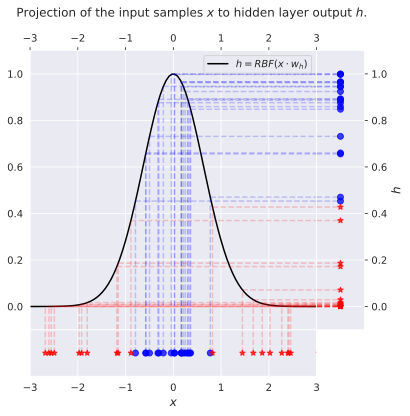

In [ ]:
# Illustrate the transformation of x to h
plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[6, 1], height_ratios=[6, 1])
gs.update(wspace=0., hspace=0.)
plt.suptitle(
    'Projection of the input samples $x$ '
    'to hidden layer output $h$.')

# Plot input
ax_in = plt.subplot(gs[2])
ax_in.plot(xs_blue, np.zeros_like(xs_blue), 'bo', alpha=0.75)
ax_in.plot(xs_red, np.zeros_like(xs_red), 'r*', alpha=0.75)
ax_in.yaxis.set_visible(False)
ax_in.set_xlabel('$x$', fontsize=12)
ax_in.set_xlim(-3,3)
ax_in.set_ylim(-1,1)
# Plot red star projections
for xr in xs_red:
    ax_in.plot((xr, xr), (0, 1), 'r--', alpha=0.2)
# Plot blue circle projections
for xb in xs_blue:
    ax_in.plot((xb, xb), (0, 2), 'b--', alpha=0.2)

# Plot RBF function
ax_rbf = plt.subplot(gs[0])
xs_rbf = np.linspace(-3, 3, 100)
ax_rbf.plot(
    xs_rbf, hidden_activations(xs_rbf, wh), 
    'k-', label='$h = RBF(x \cdot w_h)$')
ax_rbf.legend()
ax_rbf.set_xlim(-3, 3)
ax_rbf.set_ylim(-0.1, 1.1)
ax_rbf.xaxis.set_ticks_position('top')
# Plot red star projections
for xr in xs_red:
    xr = float(xr)
    h = hidden_activations(xr, wh)
    ax_rbf.plot((xr, xr), (-0.1, h), 'r--', alpha=0.2)
    ax_rbf.plot((xr, 3), [h, h], 'r--', alpha=0.2)
# Plot blue circle projections
for xb in xs_blue:
    xb = float(xb)
    h = hidden_activations(xb, wh)
    ax_rbf.plot((xb, xb), (-0.1, h), 'b--', alpha=0.2)
    ax_rbf.plot((xb, 3), [h, h], 'b--', alpha=0.2)

# Plot output
ax_out = plt.subplot(gs[1])
ax_out.plot(
    np.zeros_like(xs_blue), hidden_activations(xs_blue, wh), 
    'bo', alpha=0.75)
ax_out.plot(
    np.zeros_like(xs_red), hidden_activations(xs_red, wh), 
    'r*', alpha=0.75)
ax_out.xaxis.set_visible(False)
ax_out.yaxis.set_label_position('right')
ax_out.yaxis.set_ticks_position('right')
ax_out.set_ylabel('$h$', fontsize=12)
ax_out.set_ylim(-0.1, 1.1)
ax_out.set_xlim(-1, 1)
# Plot red star projections
for xr in xs_red:
    h = hidden_activations(xr, wh)
    ax_out.plot((-1, 0), (h, h), 'r--', alpha=0.2)
# Plot blue circle projections
for xb, in xs_blue:
    h = hidden_activations(xb, wh)
    ax_out.plot((-1, 0), (h, h), 'b--', alpha=0.2)

plt.show()
#

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2db1e377-c568-4b8a-aa7c-fac7f5fb3638' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>